<a href="https://colab.research.google.com/github/Rayeeeeen/Generative-AI/blob/main/Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

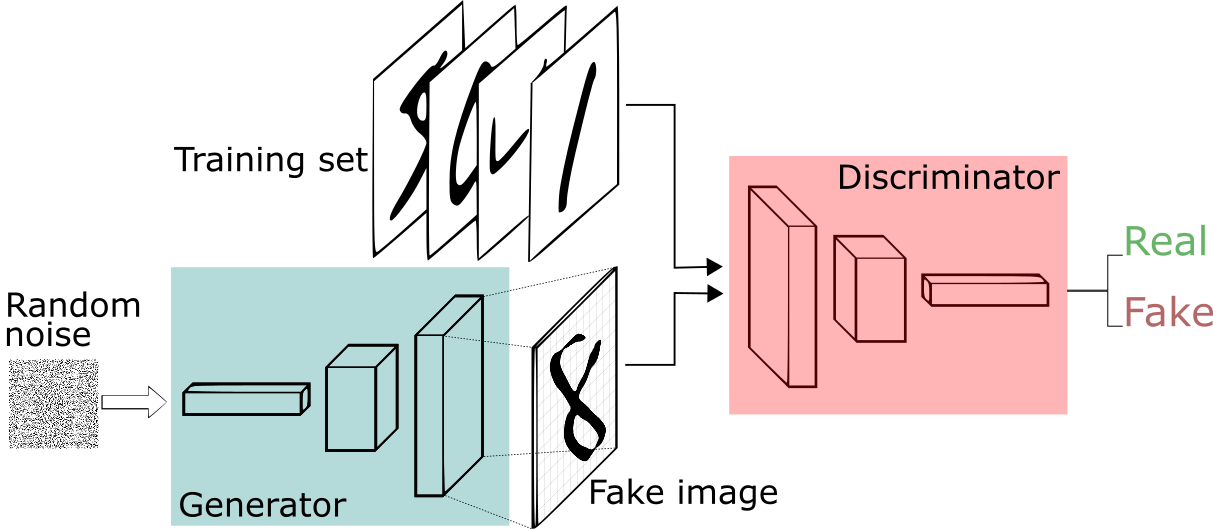

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda' #transforme the tensors and the images to the GPU
                # image = image.to(device)
batch_size = 128 #trainloader, training loop

noise_dim = 64  #generator model

#optimizer parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#training variables

epochs = 20

# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
              T.RandomRotation((-20,+20)),
              T.ToTensor() #image are numpy array and we need to make sur that it is converted to torch tensor
                            #(h,w,c) -> (c,h,w)
])

In [5]:
train_set = datasets.MNIST('MNIST/', download=True, train=True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 99417282.99it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99047991.68it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30831708.64it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18108867.65it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



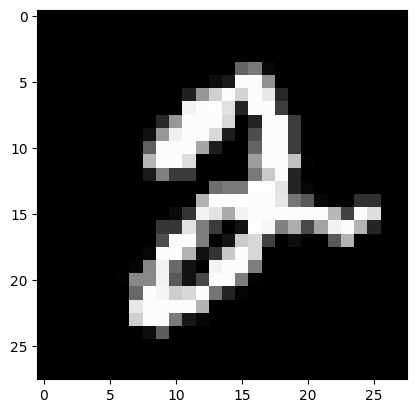

In [6]:
image, label = train_set[5]
plt.imshow(image.squeeze(),cmap='gray')

In [7]:
print("total images present in train_set are : ",len(train_set))

total images present in train_set are :  60000


# Load Dataset Into Batches

In [8]:
!pip install DataLoader

  Preparing metadata (setup.py) ... done
  Created wheel for DataLoader: filename=dataloader-2.0-py3-none-any.whl size=10084 sha256=41e93471278bb19c12ede3e5faea259b0c8d9ef3cdb027625f66d20192c1ff1e
  Stored in directory: /root/.cache/pip/wheels/60/56/53/2b1c14a2abb6f40f1d59f97461a59e61f326433fac416794de
Successfully built DataLoader


In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

In [11]:
print("Total nomber of batches in trainloader : ", len(trainloader))

Total nomber of batches in trainloader :  469


In [12]:
dataiter = iter(trainloader)  # load one batch from this trainloader
images, _ = next(dataiter)
print(images.shape)


torch.Size([128, 1, 28, 28])


In [13]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

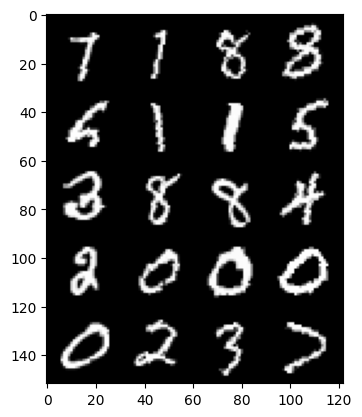

In [14]:
show_tensor_images(images, num_images = 20)

# Create Discriminator Network

In [15]:
#In case if torch summary is not installed

!pip install torchsummary

In [16]:
from torch import nn
from torchsummary import summary

In [17]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [18]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [19]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self,images) :

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5


In [20]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [21]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [22]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()

  )

In [23]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, random_noise_vec) :

    #(bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x = random_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4




In [24]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

This code defines a function called weights_init that is intended to initialize the weights of a neural network using a normal distribution. This function is designed to be used as the initialization function when constructing a neural network, specifically for layers such as nn.Conv2d (2D convolutional layer) or nn.ConvTranspose2d (2D transposed convolutional layer), and nn.BatchNorm2d (2D batch normalization layer).

In [25]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [26]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [27]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()  #Binary Cross Entropy loss with logits.
                                      #This loss is commonly used for binary classification problems when the model's output is a raw score (logit) before the sigmoid activation function.
                                      #The BCEWithLogitsLoss function combines the sigmoid activation and binary cross-entropy loss in a numerically stable way.
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [28]:
Disc_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1,beta_2))
Gen_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1,beta_2))


# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6856726161452499 | G_loss : 0.689560828813866


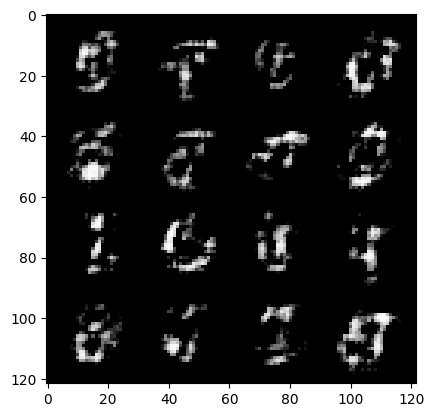

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.677407830000432 | G_loss : 0.7124930448623609


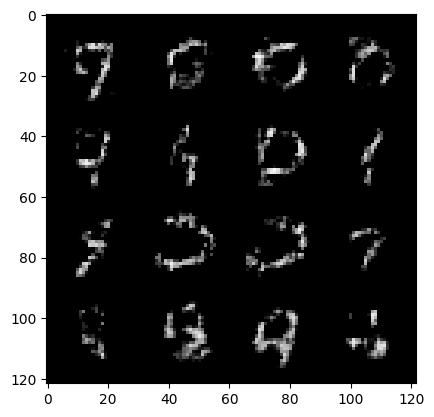

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6240447172478064 | G_loss : 0.7723795185719472


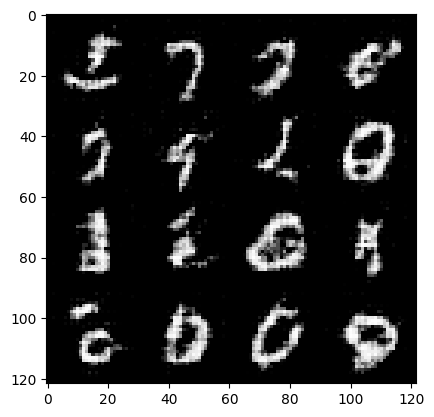

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.5841571331532525 | G_loss : 0.8306919223209942


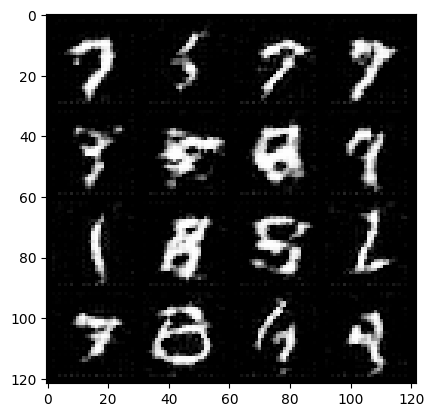

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.568078885454613 | G_loss : 0.870460555624606


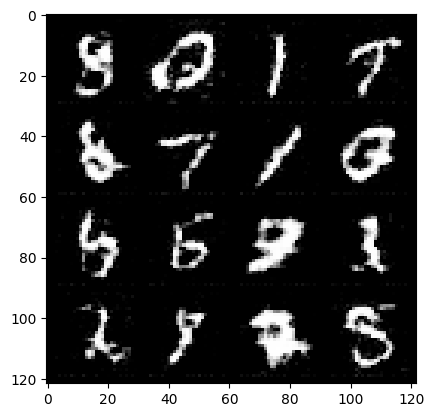

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.5680172912347545 | G_loss : 0.8862904667345954


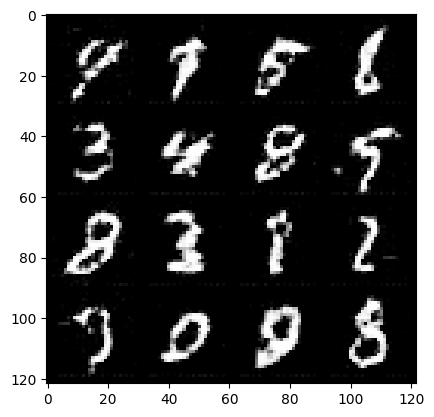

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.5752113921555884 | G_loss : 0.8919764115357958


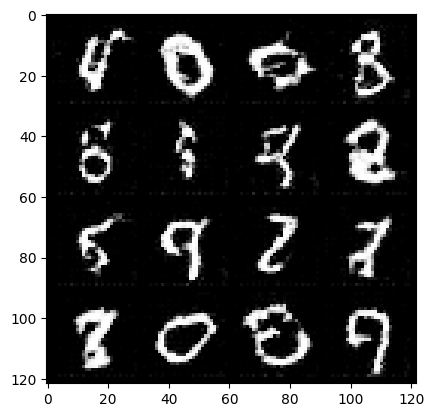

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.586120368829414 | G_loss : 0.8881894801217102


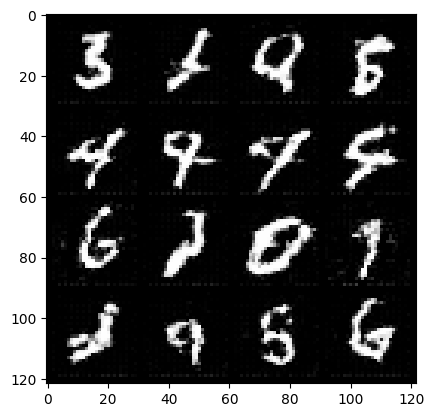

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.5962967915829819 | G_loss : 0.8837930263995107


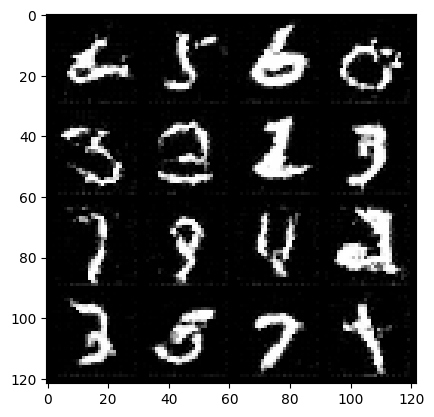

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6048165149271869 | G_loss : 0.8752163478306362


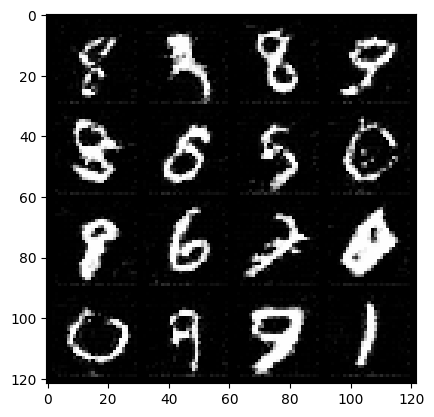

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6126833292467 | G_loss : 0.8688377838399111


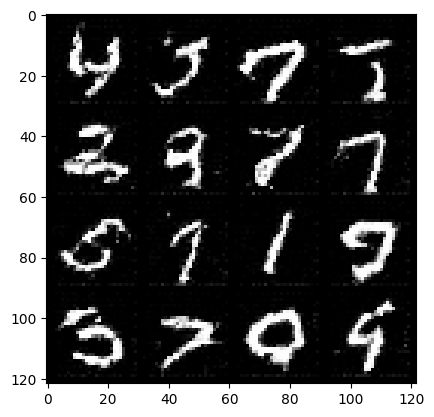

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6166329439769167 | G_loss : 0.8638127727040859


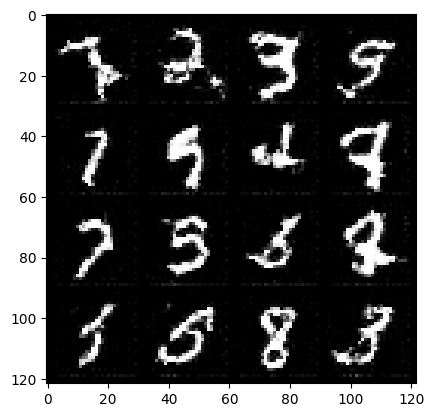

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6217603788955379 | G_loss : 0.8563229068001704


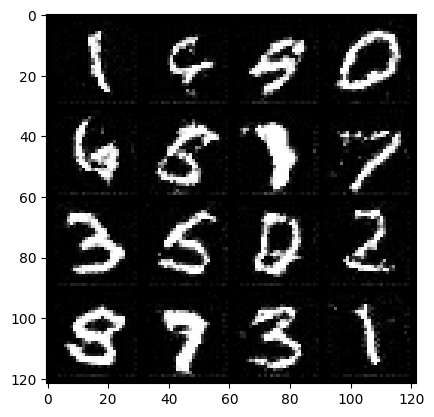

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6268436941765011 | G_loss : 0.8500778150202623


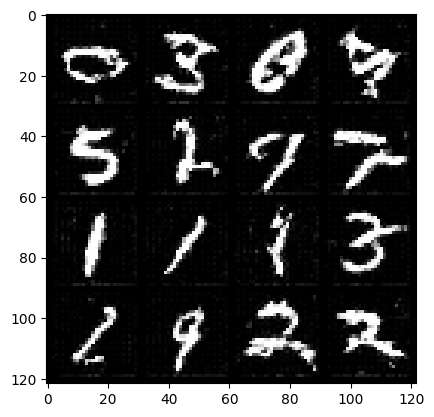

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6285234238547303 | G_loss : 0.8497926323398598


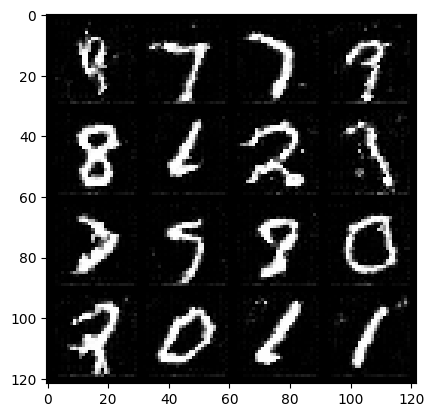

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6322148935372895 | G_loss : 0.8427632623898195


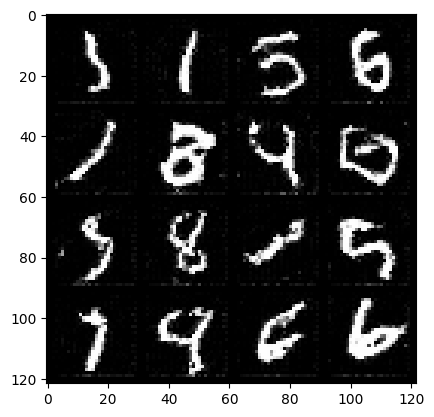

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.633871579602329 | G_loss : 0.8391589138553595


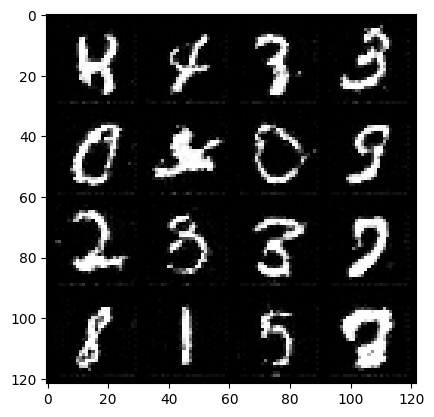

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6339167298030243 | G_loss : 0.8373261599906726


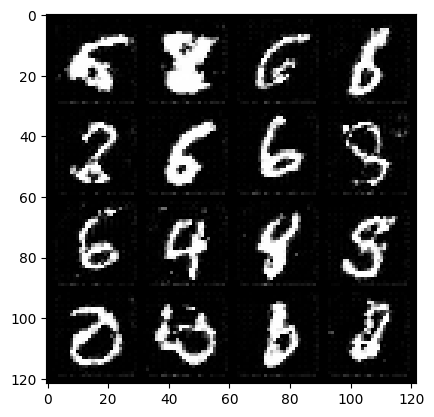

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6361522081055875 | G_loss : 0.83579687523181


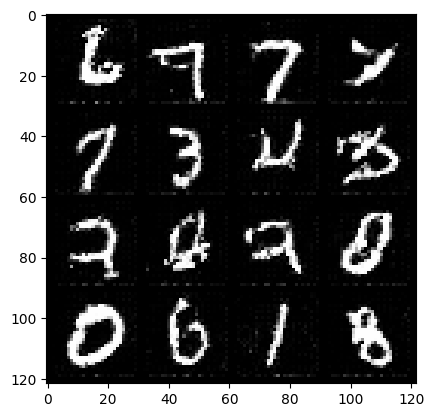

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6380158514102131 | G_loss : 0.8333115298102405


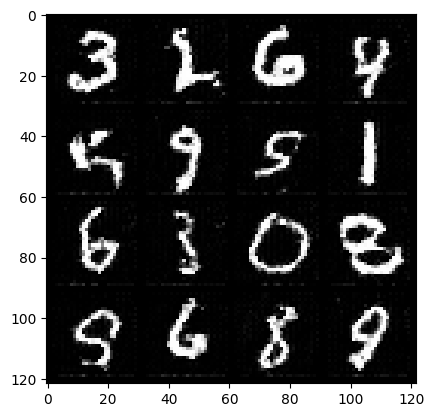

In [31]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device) #load the images to the device
    noise = torch.randn(batch_size, noise_dim, device = device)

    #find the loss and update weights for Disc

    Disc_optimizer.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    Disc_optimizer.step() #update the weights

    #for the generator networm
    #find the loss and update the weights for G

    Gen_optimizer.zero_grad()  #verfie thegradients are zero

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward() #find the gradients
    Gen_optimizer.step()
  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)

In [ ]:
  # Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya